In [35]:
from processing import get_statcast_data, populate_spray_angle, should_be_fair

# INPUT YEAR FOR ANALYSIS
analysis_year = 2025
sc = get_statcast_data(analysis_year)

fair = sc.loc[sc.act_fair]
foul = sc.loc[~sc.act_fair]


The sc DataFrame contains the x and y (hc_x and hc_y) hit coordinates and the play description for all caught ball in play (BIP) events for the given year's Regular and Post Season. In addition, it creates a column "act_fair" that indicates if the description states that the BIP was a fair ball by examining if "foul" appears in the description. The fair and foul datasets further divide the sc dataset into only fair and foul caught BIP events, respectively.

A plotting helper routine is used to plot these batted ball events (BBE) against the implied foul lines for the spray angle formula from THT.

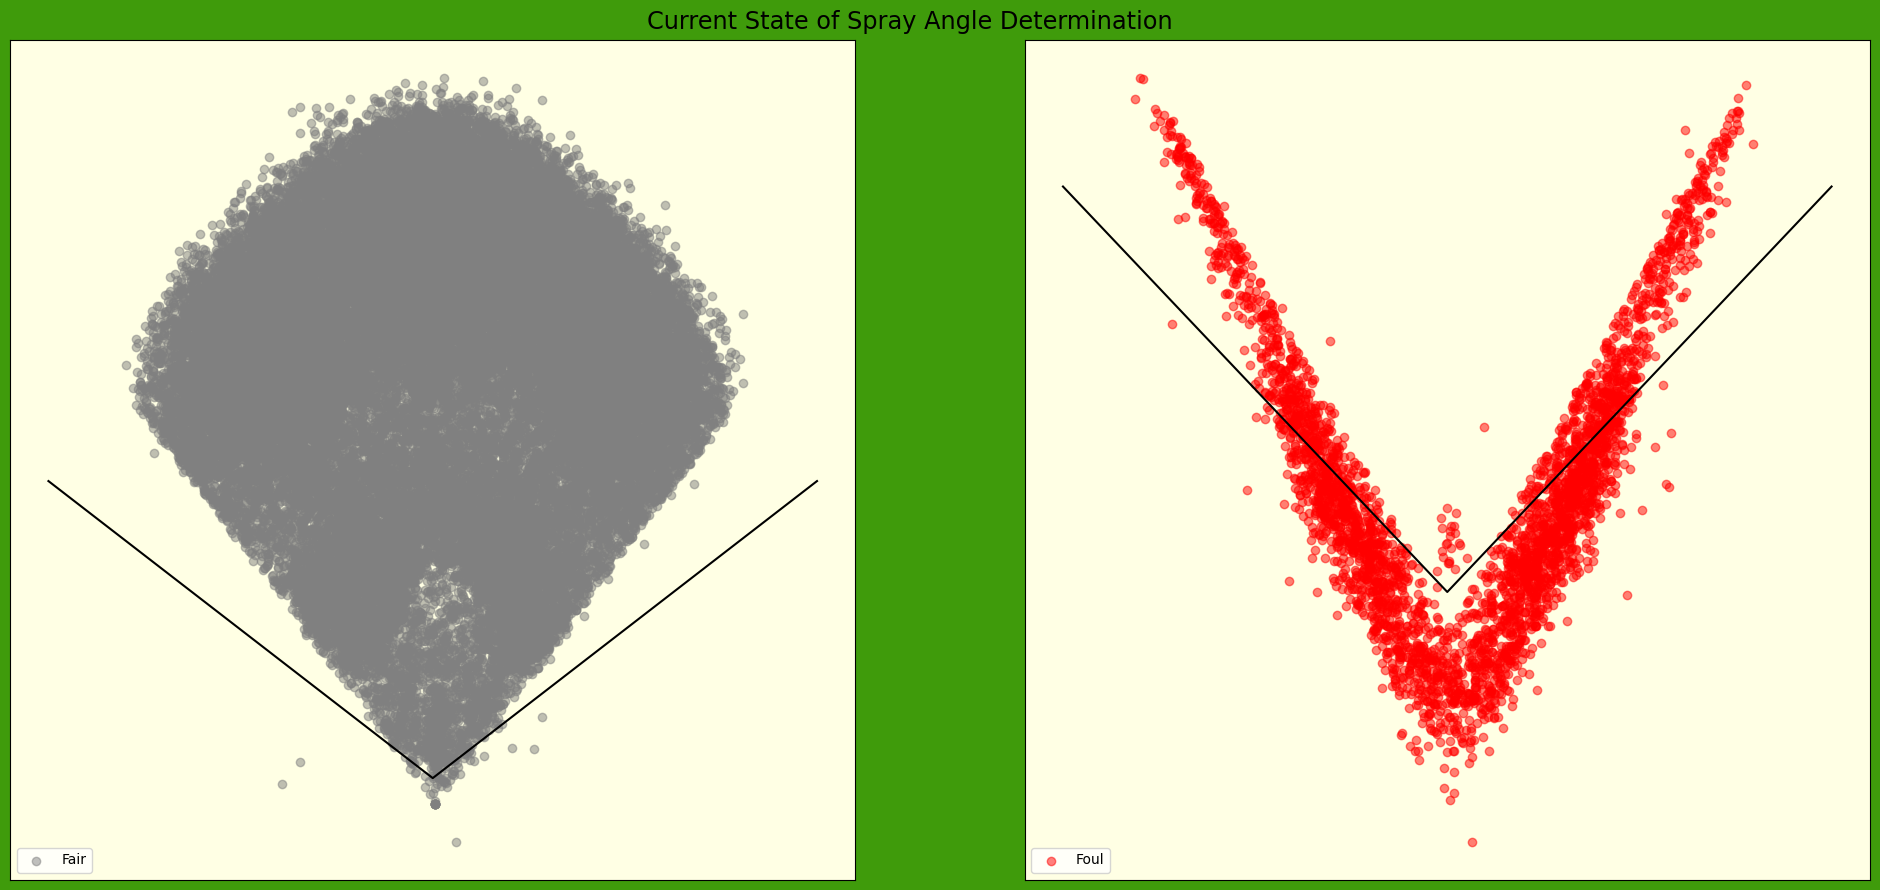

In [36]:
from plotting import plot_skewed_foul_line

hc_origin = (125.42, 198.27)

plot_skewed_foul_line(origin=hc_origin, fair_df=fair, foul_df=foul, title='Current State of Spray Angle Determination', foul_angle=60.0)

The BBE data is plotted again, this time removing the 0.75 factor while keeping the implied hit coordinate origin point of (125.47, 198.27).

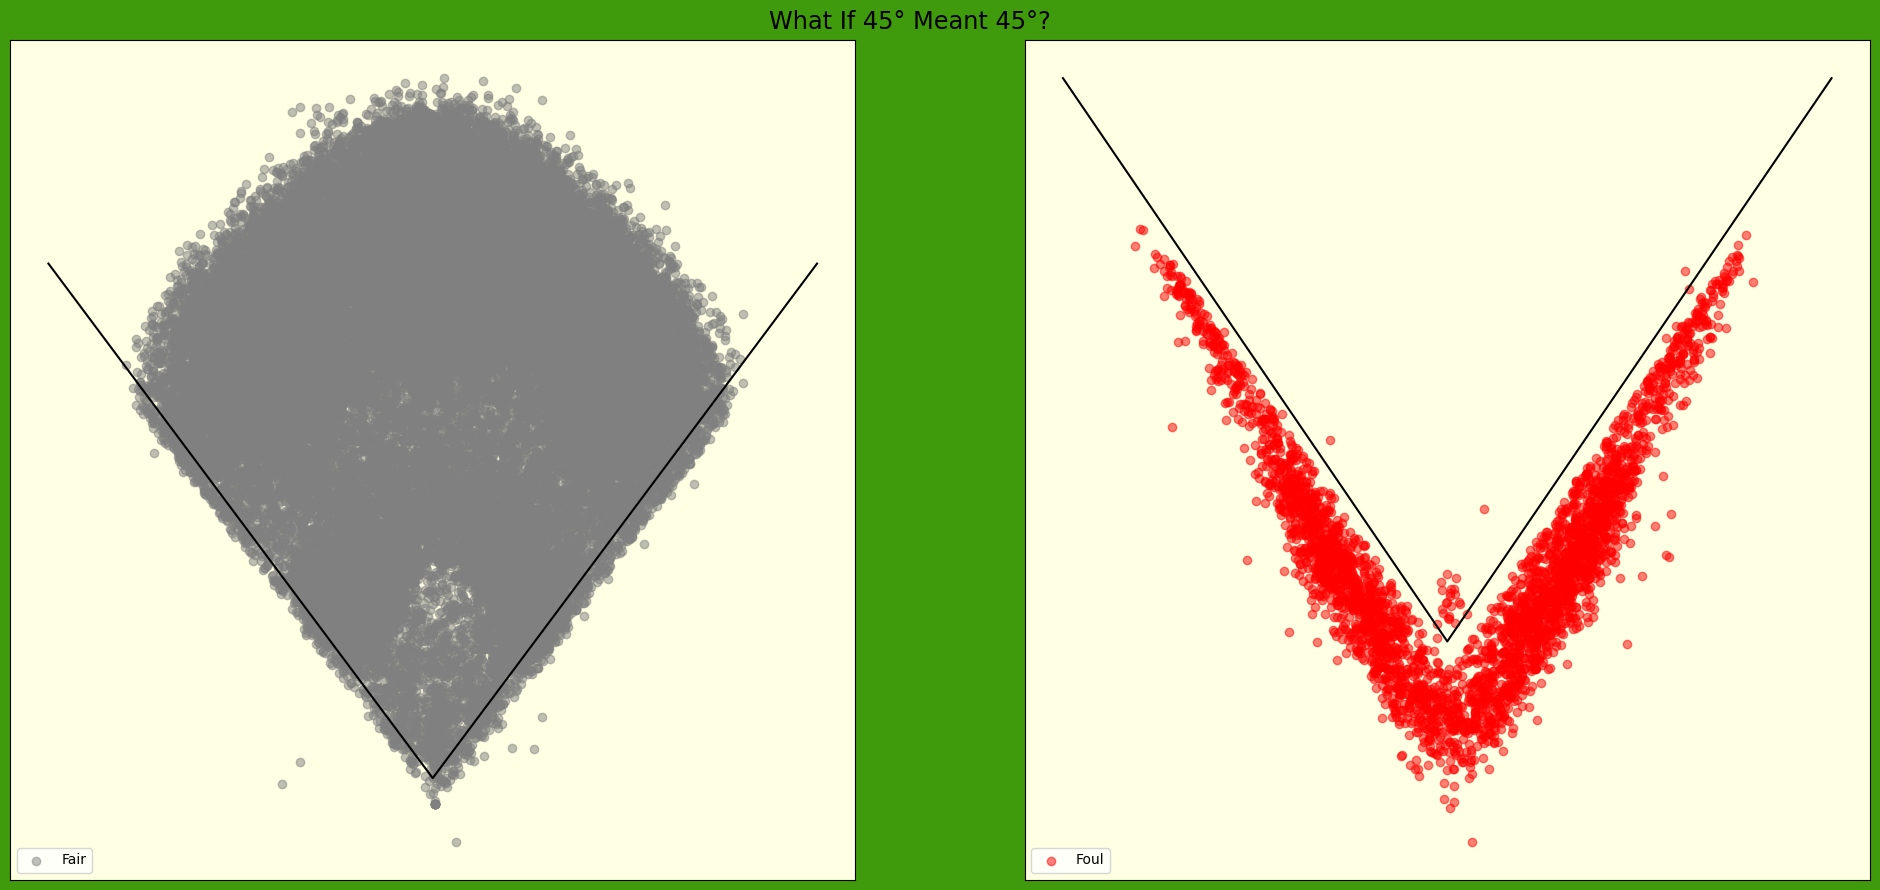

In [37]:
from plotting import plot_one_foul_line

plot_one_foul_line(origin=hc_origin, 
    fair_df=fair, 
    foul_df=foul, 
    title='What If 45° Meant 45°?')

Neither of these seem to give very good performance. For calculation performance, the dataset is minimized to only BBE that will have their outcomes changed within the envelope of y = [195, 210]. A calculation of the misclassified balls outside of this envelope is performed to show that this envelope encompasses the vast majority of them.

In [38]:
x_origin = 125.42
y_min = 195
y_max = 210

sc["spray"] = sc.apply(populate_spray_angle, axis=1, args=(x_origin, y_min))
sc['pred_fair_min'] = sc.apply(should_be_fair, axis=1)
sc["spray"] = sc.apply(populate_spray_angle, axis=1, args=(x_origin, y_max))
sc['pred_fair_max'] = sc.apply(should_be_fair, axis=1)

sc_pred_fair_min = sc.loc[sc.pred_fair_min]
sc_false_fair = sc_pred_fair_min.loc[~sc_pred_fair_min.act_fair]

sc_pred_foul_max = sc.loc[~sc.pred_fair_max]
sc_false_foul = sc_pred_foul_max.loc[sc_pred_foul_max.act_fair]

print(f'False fair outside dataset: {len(sc_false_fair)}/{len(sc_pred_fair_min)} = {len(sc_false_fair)/len(sc_pred_fair_min)*100:.2f}%')
print(f'False foul outside dataset: {len(sc_false_foul)}/{len(sc_pred_foul_max)} = {len(sc_false_foul)/len(sc_pred_foul_max)*100:.2f}%')

test_set = sc.loc[sc.pred_fair_max != sc.pred_fair_min].copy()
test_set_fair = test_set.loc[test_set.act_fair]
test_set_foul = test_set.loc[~test_set.act_fair]


False fair outside dataset: 22/39434 = 0.06%
False foul outside dataset: 8/2902 = 0.28%


The calculational dataset is plotted against the foul line envelope, seprated into observed fair and foul BBE.

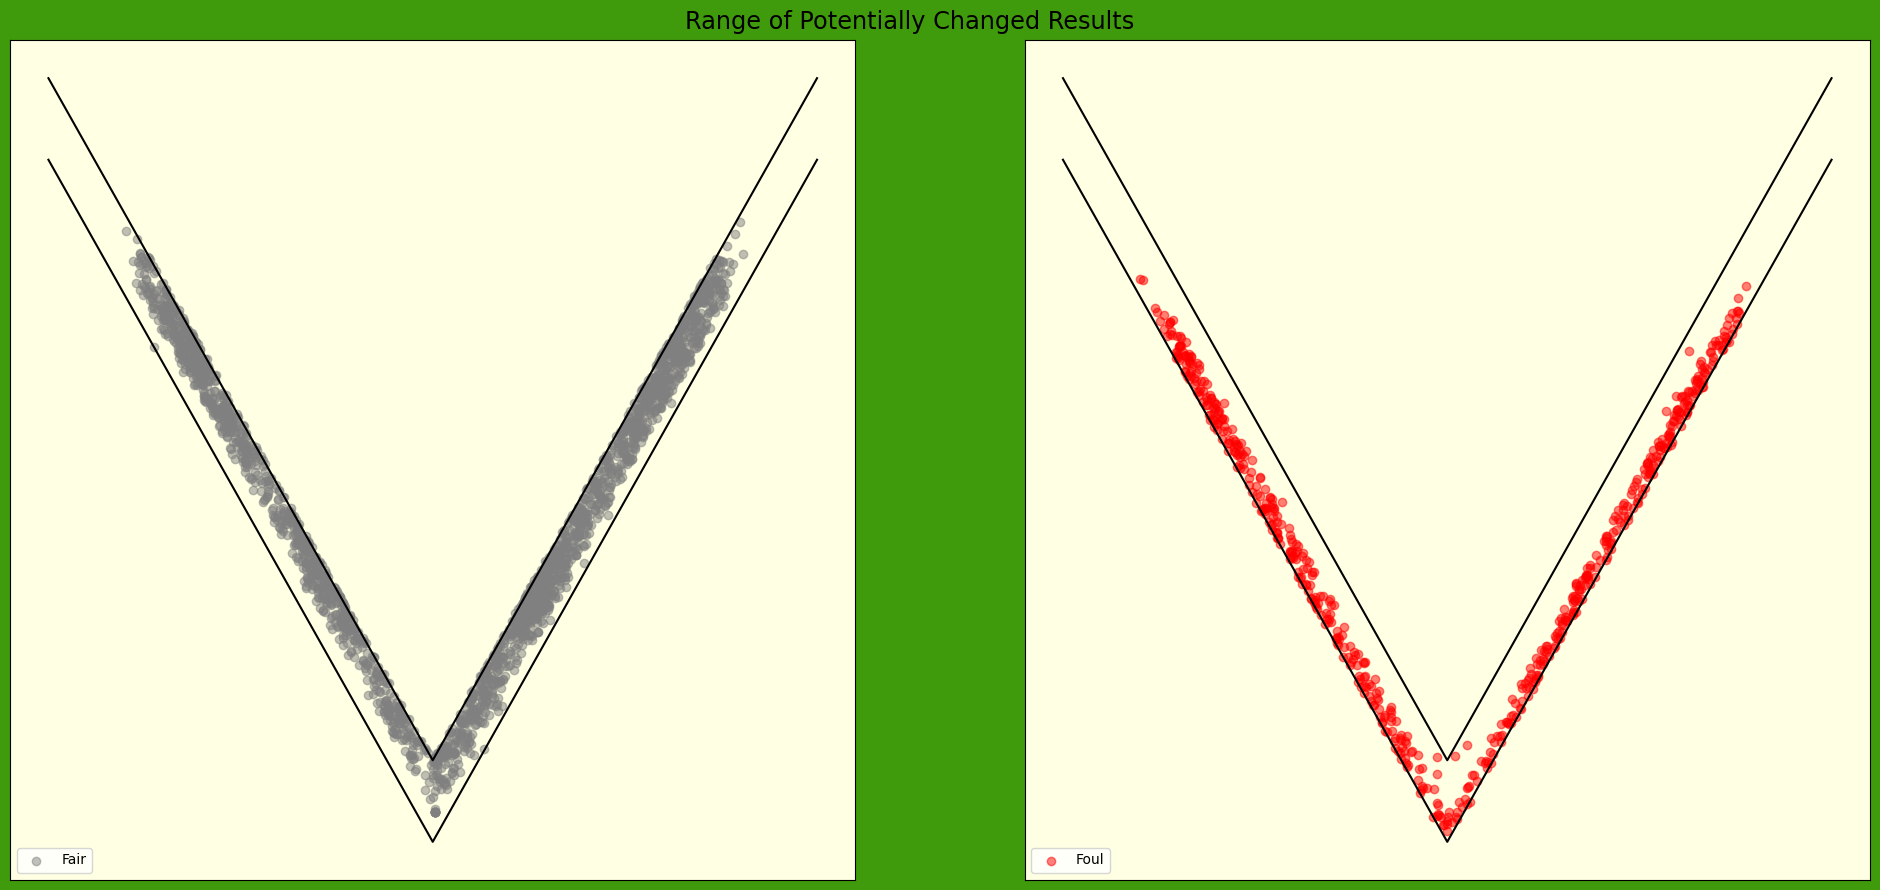

In [39]:
from plotting import plot_two_foul_lines

plot_two_foul_lines(
    origin1=(x_origin, y_min), 
    origin2=(x_origin, y_max), 
    fair_df=test_set_fair, 
    foul_df=test_set_foul, 
    title='Range of Potentially Changed Results')

Because the y coordinate appears to be a much larger misassignment, the x coordinate is held constant while y coordinates are iterated on in units of 1 to find the best F1 score.

In [40]:
from sklearn.metrics import f1_score

best_f1 = 0
best_f1_y = None
best_f1_num_misaligned = -1

for y in range(y_min, y_max):
    test_set["spray"] = test_set.apply(populate_spray_angle, axis=1, args=(x_origin, y))
    test_set["pred_fair"] = test_set.apply(should_be_fair, axis=1)

    mis_align = test_set.loc[test_set["pred_fair"] != test_set["act_fair"]]

    f1 = f1_score(test_set['act_fair'], test_set['pred_fair'])

    if f1 > best_f1:
        best_f1 = f1
        best_f1_y = y
        best_f1_num_misaligned = len(mis_align)


print(f'Best F1 Value is {best_f1:.3f} at {best_f1_y} with a total of {best_f1_num_misaligned} misalignments out of {len(test_set)} BBE')

Best F1 Value is 0.973 at 205 with a total of 123 misalignments out of 2857 BBE


Once the best integer y coordinate is found, the x coordinate is iterated on over a much smaller range of integers to find the best int, int hit coordinate origin point.

In [41]:
best_f1 = 0
best_f1_x = None
best_f1_num_misaligned = -1

x_min = 120
x_max = 130

for x in range(x_min, x_max):
    test_set["spray"] = test_set.apply(populate_spray_angle, axis=1, args=(x, best_f1_y))
    test_set["pred_fair"] = test_set.apply(should_be_fair, axis=1)

    mis_align = test_set.loc[test_set["pred_fair"] != test_set["act_fair"]]

    f1 = f1_score(test_set['act_fair'], test_set['pred_fair'])

    if f1 > best_f1:
        best_f1 = f1
        best_f1_x = x
        best_f1_num_misaligned = len(mis_align)


print(f'Best F1 Value is {best_f1:.3f} at {best_f1_x} with a total of {best_f1_num_misaligned} misalignments out of {len(test_set)} BBE')

Best F1 Value is 0.978 at 126 with a total of 101 misalignments out of 2857 BBE


Finally, a range of +/-1 about both the best x and y integer coordinates is iterated on to find the final best estimate hit coordinate origin point.

In [42]:
best_f1 = 0
best_f1_coord = None
best_f1_num_misaligned = -1

new_x_min = (best_f1_x-1)*10
new_x_max = (best_f1_x+1)*10

new_y_min = (best_f1_y-1)*10
new_y_max = (best_f1_y+1)*10

for x10 in range(new_x_min, new_x_max):
    x = x10/10
    for y10 in range(new_y_min, new_y_max):
        y = y10/10
        test_set["spray"] = test_set.apply(populate_spray_angle, axis=1, args=(x, y))
        test_set["pred_fair"] = test_set.apply(should_be_fair, axis=1)

        mis_align = test_set.loc[test_set["pred_fair"] != test_set["act_fair"]]

        f1 = f1_score(test_set['act_fair'], test_set['pred_fair'])

        if f1 > best_f1:
            best_f1 = f1
            best_f1_coord = (x, y)
            best_f1_num_misaligned = len(mis_align)


print(f'Best F1 Value is {best_f1:.3f} at {best_f1_coord} with a total of {best_f1_num_misaligned} misalignments out of {len(test_set)} BBE')

Best F1 Value is 0.982 at (125.9, 204.6) with a total of 79 misalignments out of 2857 BBE


A comparison to the performance of the legacy hti coordinate origin point.

In [43]:
test_set['spray'] = test_set.apply(populate_spray_angle, axis=1, args=(hc_origin[0], hc_origin[1]))
test_set['pred_fair'] = test_set.apply(should_be_fair, axis=1)

mis_align = test_set.loc[test_set["pred_fair"] != test_set["act_fair"]]

f1 = f1_score(test_set['act_fair'], test_set['pred_fair'])
print(f'F1 Value is {f1:.3f} at legacy hc_origin {hc_origin} with a total of {len(mis_align)} misalignments out of {len(test_set)} BBE')


F1 Value is 0.581 at legacy hc_origin (125.42, 198.27) with a total of 1317 misalignments out of 2857 BBE


A plot of the full BBE data versus the new proposed hit coordinate origin point.

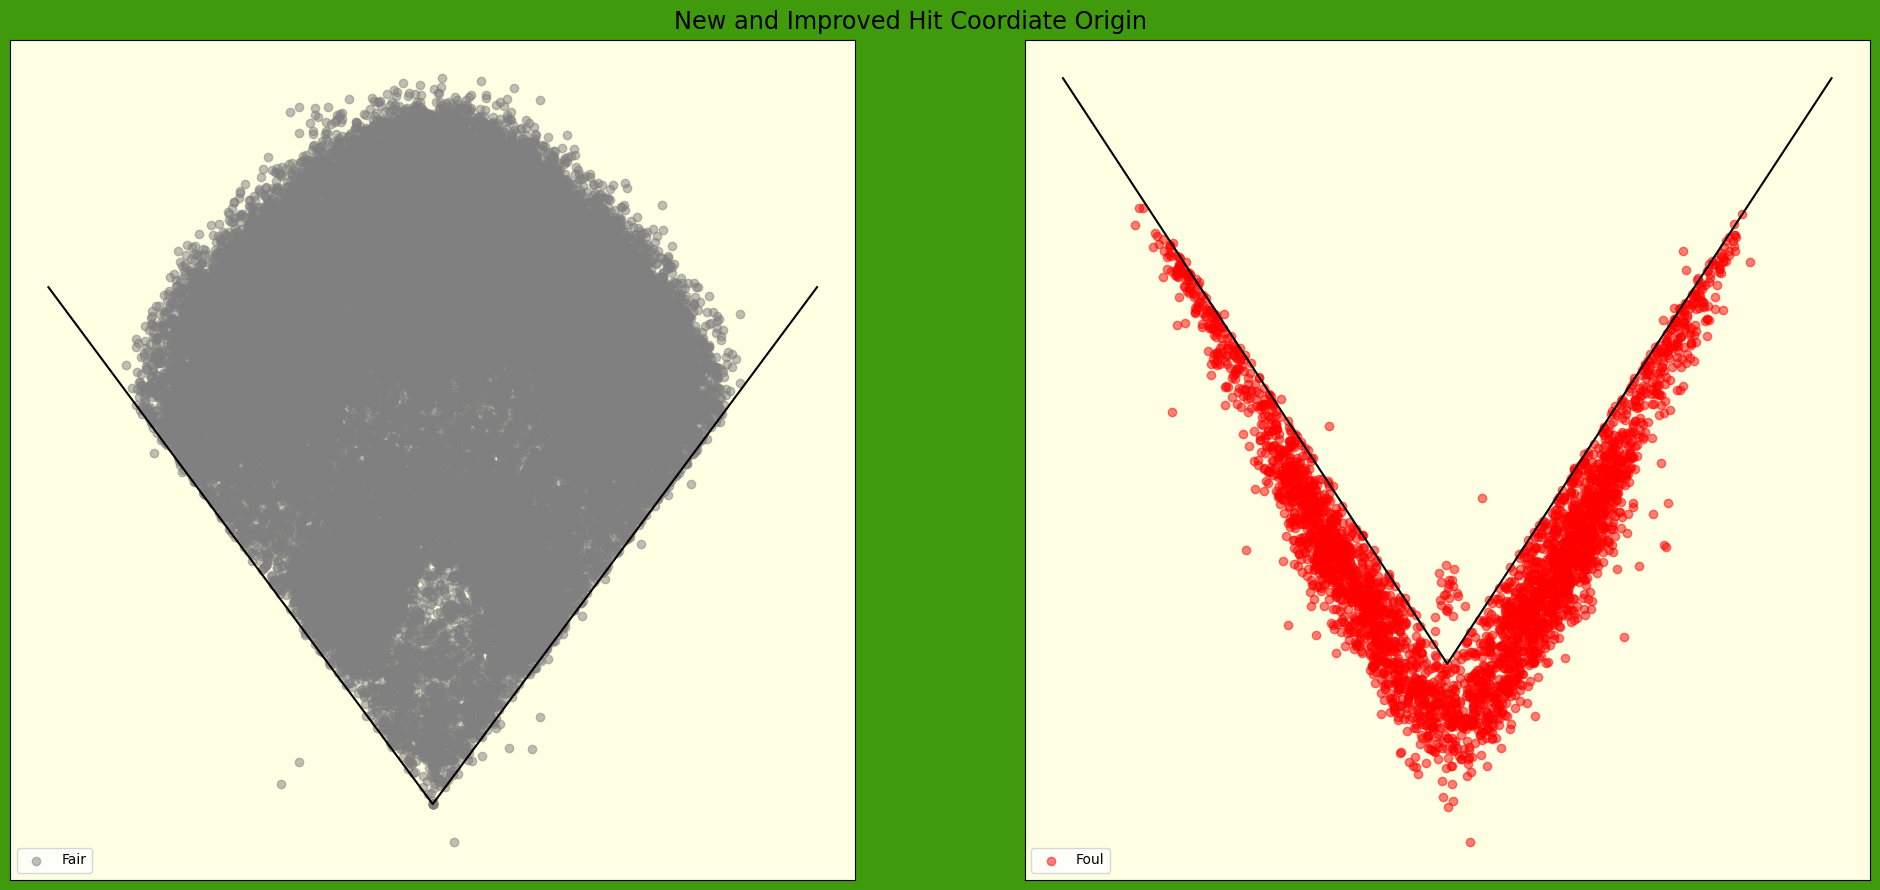

In [44]:
plot_one_foul_line(origin=(126.0, 204.6), fair_df=fair, foul_df=foul, title='New and Improved Hit Coordiate Origin')